# Imports

In [1]:
# Import standard libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# API
import requests
import snowflake.connector

# Date
import datetime as dt
import time
from datetime import timedelta

In [2]:
# # Gets the cursor
# con = snowflake.connector.connect(
#     user='meagan',
#     password='',
#     account='hu40871.us-east-1',
#     warehouse='ANALYSIS'
#     )
# cur = con.cursor()

# # insert query here
# cur.execute('''
#     SELECT  * 
#     FROM    "WAREHOUSE"."GOLD"."SUBSCRIPTION_RETENTION"
#            ''')

## Acuity

In [19]:
silver = pd.read_csv('Acuity.csv')

In [20]:
# Create a copy of the DB
silver_acuity = silver.copy()
silver_acuity.shape

(19861, 20)

In [21]:
# Change dates to datetime Dtype
silver_acuity['APPOINTMENT_BODY_DATE'] = pd.to_datetime(silver_acuity['APPOINTMENT_BODY_DATE'])

# Drop unneeded columns
silver_acuity.drop(columns=['EVENT_TS', 'EVENT_TS_UTC', 'ANONYMOUS_ID','APPOINTMENT_BODY_FIRST_NAME',
       'APPOINTMENT_BODY_DATETIME_CREATED', 'APPOINTMENT_BODY_CALENDAR_ID','APPOINTMENT_BODY_CALENDAR_TIMEZONE',\
                    'APPOINTMENT_BODY_TIMEZONE', 'APPOINTMENT_BODY_LAST_NAME', 'APPOINTMENT_BODY_ID',\
                    'APPOINTMENT_BODY_NO_SHOW', \
                    'APPOINTMENT_TYPE_ID'], inplace=True)

# Check for null values
# sns.heatmap(silver_acuity.isnull(), cbar=False)
silver_acuity.isnull().sum()

EVENT                          0
APPOINTMENT_BODY_CALENDAR    278
EMAIL                        353
APPOINTMENT_BODY_DATE        278
APPOINTMENT_BODY_DURATION    278
APPOINTMENT_DATE_TIME        278
APPOINTMENT_BODY_TYPE        278
APPOINTMENT_BODY_CANCELED    278
dtype: int64

In [22]:
# drop irrelevant appointments
na_dict= {'appointment_canceled' : np.nan,
'appointment_changed' : np.nan,
'appointment_rescheduled' : np.nan}

silver_acuity['EVENT'].replace(na_dict, inplace = True)
silver_acuity.dropna(inplace = True)
silver_acuity['EVENT'].value_counts()

appointment_scheduled    4006
Name: EVENT, dtype: int64

In [23]:
# drop irrelevant appointments
na_dict= {'True' : np.nan}

silver_acuity['APPOINTMENT_BODY_CANCELED'].replace(na_dict, inplace = True)
silver_acuity.dropna(inplace = True)
# silver_acuity['APPOINTMENT_BODY_CANCELED'].value_counts()

In [24]:
silver_acuity.head()

,EVENT,APPOINTMENT_BODY_CALENDAR,EMAIL,APPOINTMENT_BODY_DATE,APPOINTMENT_BODY_DURATION,APPOINTMENT_DATE_TIME,APPOINTMENT_BODY_TYPE,APPOINTMENT_BODY_CANCELED
0,appointment_scheduled,"Dr. Anya Arthen, ND",ginger.deshotels@icloud.com,2020-11-04,20.0,2020-11-04 12:50:00.000,Hair Consultation,False
1,appointment_scheduled,"Dr. Ariana Zastrow, ND",vburgess53@icloud.com,2020-10-08,15.0,2020-10-08 17:30:00.000,Follow Up Consultation,False
2,appointment_scheduled,"Dr. Katelyn Cloyd, ND",ruciglione@gmail.com,2021-01-07,20.0,2021-01-07 17:05:00.000,Hair Consultation,False
3,appointment_scheduled,"Dr. Katelyn Cloyd, ND",njoymann50@aol.com,2020-12-22,20.0,2020-12-22 13:00:00.000,Hair Consultation,False
4,appointment_scheduled,"Dr. Anya Arthen, ND",kendralinde@gmail.com,2021-01-22,20.0,2021-01-22 13:15:00.000,Hair Consultation,False


In [25]:
silver_acuity['APPOINTMENT_BODY_CANCELED'].value_counts()

False    4005
True        1
Name: APPOINTMENT_BODY_CANCELED, dtype: int64

In [26]:
# drop irrelevant appointments
na_dict= {'Hair Mineral Analysis Appointment':np.nan,
          'Follow Up Consultation':np.nan,
          'Customer consultation':np.nan,
          'Case Study':np.nan}

silver_acuity['APPOINTMENT_BODY_TYPE'].replace(na_dict, inplace = True)
silver_acuity.dropna(inplace = True)
silver_acuity['APPOINTMENT_BODY_TYPE'].value_counts()

Hair Consultation                      3400
Hair Mineral Analysis - Acquisition       3
Name: APPOINTMENT_BODY_TYPE, dtype: int64

In [27]:
#Round to the day
silver_acuity['APPOINTMENT_BODY_DATE'] = silver_acuity['APPOINTMENT_BODY_DATE'].dt.round('D')

silver_acuity['Today'] = pd.Timestamp('today')
silver_acuity['Today'] = silver_acuity['Today'].dt.round('D')

silver_acuity['Complete'] = (silver_acuity['Today']>silver_acuity['APPOINTMENT_BODY_DATE'])
silver_acuity['Complete'].value_counts()

True     3161
False     242
Name: Complete, dtype: int64

In [28]:
# Remove appointments in the future
silver_acuity['Complete'] = silver_acuity['Complete'].astype('str')

# drop irrelevant appointments
na_dict= {'False' : np.nan}

silver_acuity['Complete'].replace(na_dict, inplace = True)
silver_acuity.dropna(inplace = True)
silver_acuity['Complete'].value_counts()

True    3161
Name: Complete, dtype: int64

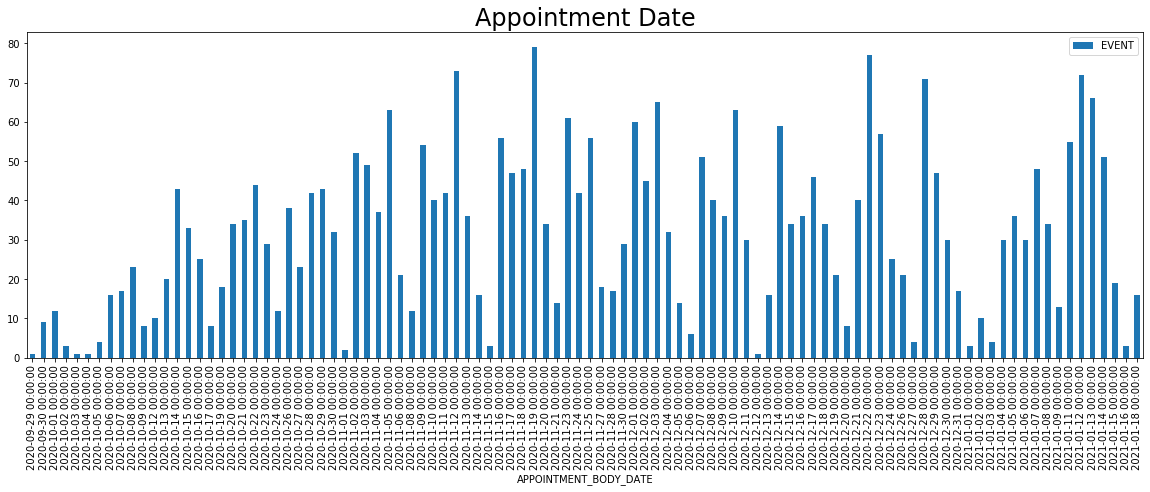

In [29]:
# Group by event, for a visual only 
chart = silver_acuity.groupby(["APPOINTMENT_BODY_DATE"]).agg({'EVENT':'count'})
chart.isna().sum()

chart.plot(kind='bar',figsize=(20,6))
plt.title("Appointment Date", size= 24)
plt.show()

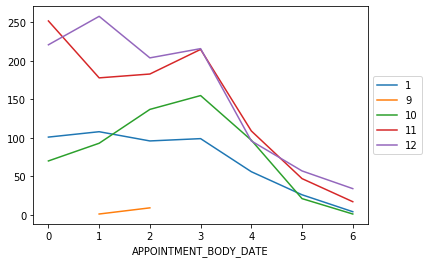

In [30]:
(silver_acuity.groupby([silver_acuity['APPOINTMENT_BODY_DATE'].dt.dayofweek,\
                       silver_acuity['APPOINTMENT_BODY_DATE'].dt.month])\
 ['EVENT'].count()).unstack().plot(kind='line')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

In [31]:
min(silver_acuity['APPOINTMENT_BODY_DATE'])

Timestamp('2020-09-29 00:00:00')

In [32]:
max(silver_acuity['APPOINTMENT_BODY_DATE'])

Timestamp('2021-01-18 00:00:00')

In [33]:
# Looking at specific email addresses
# silver_acuity.loc[silver_acuity['EMAIL']=='XXXX@yahoo.com']

# AGG
clean_acuity = silver_acuity.loc[silver_acuity.groupby('EMAIL')['APPOINTMENT_BODY_DATE'].idxmin()]
clean_acuity.shape

(2815, 10)

In [34]:
clean_acuity['APPOINTMENT_BODY_TYPE'].value_counts()

Hair Consultation                      2814
Hair Mineral Analysis - Acquisition       1
Name: APPOINTMENT_BODY_TYPE, dtype: int64

In [35]:
clean_acuity['APPOINTMENT_BODY_CANCELED'].value_counts()

False    2815
Name: APPOINTMENT_BODY_CANCELED, dtype: int64

In [36]:
#QA instances
smail = clean_acuity['EMAIL'].nunique()
print ('unique emails = ',smail)

unique emails =  2815


## SUB

In [40]:
gold_sub = pd.read_csv('GOLD.csv')

In [41]:
# Create a copy of the dataframe
gold = gold_sub.copy()
gold.columns

Index(['SUBSCRIPTION_ID', 'CUSTOMER_ID', 'EMAIL', 'STATUS', 'ITEM_NAME',
       'ITEM_GROUP', 'ITEM_SUB_TYPE', 'ITEM_GENDER', 'TOTAL_ITEMS',
       'FIRST_ORDER_AT', 'GROSS_ORDER_VALUE', 'TOTAL_ORDERS',
       'TOTAL_ORDER_VALUE'],
      dtype='object')

In [42]:
# Change dates to datetime 
gold['FIRST_ORDER_AT'] = pd.to_datetime(gold['FIRST_ORDER_AT'])
gold.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161570 entries, 0 to 161569
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   SUBSCRIPTION_ID    161570 non-null  int64         
 1   CUSTOMER_ID        161570 non-null  int64         
 2   EMAIL              161570 non-null  object        
 3   STATUS             113040 non-null  object        
 4   ITEM_NAME          161543 non-null  object        
 5   ITEM_GROUP         161543 non-null  object        
 6   ITEM_SUB_TYPE      161543 non-null  object        
 7   ITEM_GENDER        161543 non-null  object        
 8   TOTAL_ITEMS        161543 non-null  float64       
 9   FIRST_ORDER_AT     161570 non-null  datetime64[ns]
 10  GROSS_ORDER_VALUE  161543 non-null  float64       
 11  TOTAL_ORDERS       161517 non-null  float64       
 12  TOTAL_ORDER_VALUE  161517 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(2), 

In [43]:
# min(gold['FIRST_ORDER_AT'])
# max(gold['FIRST_ORDER_AT'])

yyy = gold.shape
gemail = gold['EMAIL'].nunique()
print ('shape = ',yyy)
print ('unique emails = ',gemail)

shape =  (161570, 13)
unique emails =  42765


In [44]:
# clean up item gender
gold.loc[gold['ITEM_GENDER'] =='Men,Women', 'ITEM_GENDER']= 'Combination'
gold.loc[gold['ITEM_GENDER'] =='Women,Men,Women', 'ITEM_GENDER']= 'Combination'
gold.loc[gold['ITEM_GENDER'] =='Men,Women,Men,Women,Women,Women,Men,Men', 'ITEM_GENDER']= 'Combination'
gold.loc[gold['ITEM_GENDER'] =='Men,Women,Women', 'ITEM_GENDER']= 'Combination'
gold.loc[gold['ITEM_GENDER'] =='Women,Women,Men', 'ITEM_GENDER']= 'Combination'
gold.loc[gold['ITEM_GENDER'] =='Women,Men,Women,Women', 'ITEM_GENDER']= 'Combination'
gold.loc[gold['ITEM_GENDER'] =='Women,Men', 'ITEM_GENDER']= 'Combination'
gold.loc[gold['ITEM_GENDER'] =='Women,All', 'ITEM_GENDER']= 'Women'
gold.loc[gold['ITEM_GENDER'] =='Women,Women,Women,Women', 'ITEM_GENDER']= 'Women'
gold.loc[gold['ITEM_GENDER'] =='Women,Women', 'ITEM_GENDER']= 'Women'
gold.loc[gold['ITEM_GENDER'] =='Men,Men', 'ITEM_GENDER']= 'Men'

gold['ITEM_GENDER'].value_counts()

Women          131927
Men             26195
Combination      3421
Name: ITEM_GENDER, dtype: int64

In [52]:
# AGG
df = gold.loc[gold.groupby('EMAIL')['GROSS_ORDER_VALUE'].idxmin()]
df.shape

(42765, 13)

In [ ]:
# clean up item sub
gold.loc[gold['ITEM_SUB_TYPE'] =='GrowthPlan,GrowthPlan 2', 'ITEM_SUB_TYPE']= 'Combination'
gold.loc[gold['ITEM_SUB_TYPE'] =='Non-Sub,GrowthPlan 3', 'ITEM_SUB_TYPE']= 'Combination'
gold.loc[gold['ITEM_SUB_TYPE'] =='GrowthPlan,Non-Sub', 'ITEM_SUB_TYPE']= 'Combination'
gold.loc[gold['ITEM_SUB_TYPE'] =='GrowthPlan 3,GrowthPlan', 'ITEM_SUB_TYPE']= 'Combination'
gold.loc[gold['ITEM_SUB_TYPE'] =='GrowthPlan,GrowthPlan', 'ITEM_SUB_TYPE']= 'Combination'
gold.loc[gold['ITEM_SUB_TYPE'] =='GrowthPlan 3,GrowthPlan 3', 'ITEM_SUB_TYPE']= 'Combination'
gold.loc[gold['ITEM_SUB_TYPE'] =='GrowthPlan,GrowthPlan 3', 'ITEM_SUB_TYPE']= 'Combination'
gold.loc[gold['ITEM_SUB_TYPE'] =='GrowthPlan,GrowthPlan,GrowthPlan 3,GrowthPlan 3', 'ITEM_SUB_TYPE']= 'Combination'
gold.loc[gold['ITEM_SUB_TYPE'] =='GrowthPlan 3,GrowthPlan 2,GrowthPlan 3,GrowthPlan 3']= 'Combination'
gold.loc[gold['ITEM_SUB_TYPE'] =='Non-Sub,GrowthPlan 3,Non-Sub', 'ITEM_SUB_TYPE']= 'Combination'
gold.loc[gold['ITEM_SUB_TYPE'] =='GrowthPlan 3,Non-Sub', 'ITEM_SUB_TYPE']= 'Combination'
gold.loc[gold['ITEM_SUB_TYPE'] =='Prepay 6', 'ITEM_SUB_TYPE']= 'Combination'
gold.loc[gold['ITEM_SUB_TYPE'] =='GrowthPlan 3,GrowthPlan', 'ITEM_SUB_TYPE']= 'Combination'
gold.loc[gold['ITEM_SUB_TYPE'] =='GrowthPlan 3,GrowthPlan,GrowthPlan', 'ITEM_SUB_TYPE']= 'Combination'
gold.loc[gold['ITEM_SUB_TYPE'] =='Non-Sub,GrowthPlan 3,GrowthPlan 3,GrowthPlan 2,GrowthPlan 3,GrowthPlan 3,GrowthPlan 3,GrowthPlan 2', 'ITEM_SUB_TYPE']= 'Combination'
gold.loc[gold['ITEM_SUB_TYPE'] =='GrowthPlan 3,GrowthPlan 3,GrowthPlan 2,GrowthPlan 3', 'ITEM_SUB_TYPE']= 'Combination'
gold.loc[gold['ITEM_SUB_TYPE'] =='GrowthPlan 2,GrowthPlan 2', 'ITEM_SUB_TYPE']= 'Combination'
gold.loc[gold['ITEM_SUB_TYPE'] =='GrowthPlan 2,GrowthPlan ', 'ITEM_SUB_TYPE']= 'Combination'
gold.loc[gold['ITEM_SUB_TYPE'] =='GrowthPlan 3,GrowthPlan 2', 'ITEM_SUB_TYPE']= 'Combination'
gold.loc[gold['ITEM_SUB_TYPE'] =='GrowthPlan 2,GrowthPlan 3']= 'Combination'
gold.loc[gold['ITEM_SUB_TYPE'] =='GrowthPlan,GrowthPlan,GrowthPlan', 'ITEM_SUB_TYPE']= 'Combination'
gold.loc[gold['ITEM_SUB_TYPE'] =='GrowthPlan 2,Non-Sub', 'ITEM_SUB_TYPE']= 'Combination'
gold.loc[gold['ITEM_SUB_TYPE'] =='Non-Sub,GrowthPlan']= 'Combination'
gold.loc[gold['ITEM_SUB_TYPE'] =='GrowthPlan 2,GrowthPlan,GrowthPlan 3', 'ITEM_SUB_TYPE']= 'Combination'
gold.loc[gold['ITEM_SUB_TYPE'] =='GrowthPlan 3,GrowthPlan 3,Non-Sub']= 'Combination'
gold.loc[gold['ITEM_SUB_TYPE'] =='Non-Sub,GrowthPlan 2']= 'Combination'
gold.loc[gold['ITEM_SUB_TYPE'] =='GrowthPlan 2,GrowthPlan']= 'Combination'

gold['ITEM_SUB_TYPE'].value_counts()

In [42]:
df.loc[df['FIRST_ORDER_AT']>'2020-09-29 00:00:00'].count()

KeyError: 'FIRST_ORDER_AT'

In [43]:
df.head()

,TOTAL_ORDER_VALUE
EMAIL,
0127351@gmail.com,1285
01hookerville@gmail.com,158.4
03moni91@gmail.com,1188
0512mommy@gmail.com,158
06attisha@gmail.com,79


In [27]:
gross = df['GROSS_ORDER_VALUE'].mean()
orderValue = df['TOTAL_ORDER_VALUE'].mean()
Items  = df['TOTAL_ITEMS'].mean()
orders = df['TOTAL_ORDERS'].mean()

print(gross, orderValue, Items, orders)

91.69468373670057 211.9993005308691 1.0718344440547176 2.5377095951918807


In [28]:
min(df['FIRST_ORDER_AT'])

Timestamp('2020-08-01 00:09:46')

## Merge

In [46]:
sub1 = pd.merge(clean_acuity,gold,how='left',on='EMAIL')

In [47]:
gold.columns

Index(['SUBSCRIPTION_ID', 'CUSTOMER_ID', 'EMAIL', 'STATUS', 'ITEM_NAME',
       'ITEM_GROUP', 'ITEM_SUB_TYPE', 'ITEM_GENDER', 'TOTAL_ITEMS',
       'FIRST_ORDER_AT', 'GROSS_ORDER_VALUE', 'TOTAL_ORDERS',
       'TOTAL_ORDER_VALUE'],
      dtype='object')

In [48]:
# Create a copy of the dataframe
sub = sub1.copy()

sub = sub[[ 'EMAIL','APPOINTMENT_BODY_DATE', 'FIRST_ORDER_AT',\
           'ITEM_GROUP', 'ITEM_SUB_TYPE','TOTAL_ITEMS','TOTAL_ORDERS',
           'ITEM_NAME', 'ITEM_GENDER', 'GROSS_ORDER_VALUE','TOTAL_ORDER_VALUE']]
sub.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6671 entries, 0 to 6670
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   EMAIL                  6671 non-null   object        
 1   APPOINTMENT_BODY_DATE  6671 non-null   datetime64[ns]
 2   FIRST_ORDER_AT         5347 non-null   object        
 3   ITEM_GROUP             5347 non-null   object        
 4   ITEM_SUB_TYPE          5347 non-null   object        
 5   TOTAL_ITEMS            5347 non-null   object        
 6   TOTAL_ORDERS           5347 non-null   object        
 7   ITEM_NAME              5347 non-null   object        
 8   ITEM_GENDER            5347 non-null   object        
 9   GROSS_ORDER_VALUE      5347 non-null   object        
 10  TOTAL_ORDER_VALUE      5347 non-null   object        
dtypes: datetime64[ns](1), object(10)
memory usage: 625.4+ KB


In [32]:
max(sub['FIRST_ORDER_AT'])

# # create start year column to be able to make years_working column
# df['start_year'] = df['Agency Start Date'].apply(lambda x: int(x[6:]))
# df['years_with_city'] = df[['Fiscal Year']].sub(df['start_year'], axis=0)

Timestamp('2021-01-12 11:58:22')

In [45]:
sub['TimeDifference'] = \
(((sub['APPOINTMENT_BODY_DATE']))-(sub['FIRST_ORDER_AT']))

NameError: name 'sub' is not defined

In [34]:
sub['ITEM_GROUP'].value_counts()

G-Plan           846
Core             559
Core,G-Plan        7
G-Plan,G-Plan      1
Core,Core          1
G-Plan,Core        1
Name: ITEM_GROUP, dtype: int64

In [35]:
sub['ITEM_SUB_TYPE'].value_counts()

GrowthPlan      559
GrowthPlan 3    522
GrowthPlan 2    324
Combination      10
Name: ITEM_SUB_TYPE, dtype: int64

In [36]:
submail = sub['EMAIL'].nunique()
print ('unique emails = ',submail)

unique emails =  2739


In [37]:
gross = df['GROSS_ORDER_VALUE'].mean()
cgross = sub['GROSS_ORDER_VALUE'].mean()
OV = df['TOTAL_ORDER_VALUE'].mean()
COV = sub['TOTAL_ORDER_VALUE'].mean()
Items  = df['TOTAL_ITEMS'].mean()
orders = df['TOTAL_ORDERS'].mean()

print('Total Gross Order Value = ',gross)
print('Consult Gross Order Value = ',cgross)

print('Total Gross Order Value = ',OV)
print('Consult Gross Order Value = ',COV)

Total Gross Order Value =  91.69468373670057
Consult Gross Order Value =  94.2374558303887
Total Gross Order Value =  211.9993005308691
Consult Gross Order Value =  227.6218021201425


In [38]:
# Export data
sub.to_csv('sub.csv')

In [39]:
sub.shape

(2739, 12)